In [61]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
from torch.nn import KLDivLoss
from torchvision.io import read_video
from scipy.special import kl_div

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [62]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape

In [63]:
print(img_tensor.shape)

time_window = 5
patch_size = (9, 9)

pos_range = max(int(time_window / 2), 1) if time_window > 1 else 0
center_index = int(patch_size[0] / 2)

step_matrix = torch.ones(patch_size + (2,))

step_w = 2 / W
step_h = 2 / H

for k in range(0, patch_size[0]):
    for l in range(0, patch_size[1]):
        step_matrix[k, l, 0] = (l - center_index) * step_w
        step_matrix[k, l, 1] = (k - center_index) * step_h
        

hist_norm_p = 2  # 0, 1, 2, float('inf')
v_min = 0.0
v_max = 2.0
n_bins = 250  # 100

torch.Size([16, 4, 3, 256, 256])


In [64]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

perfect_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=perfect_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

N, T, K, C, Hp, Wp  = perfect_kpt_patches.shape

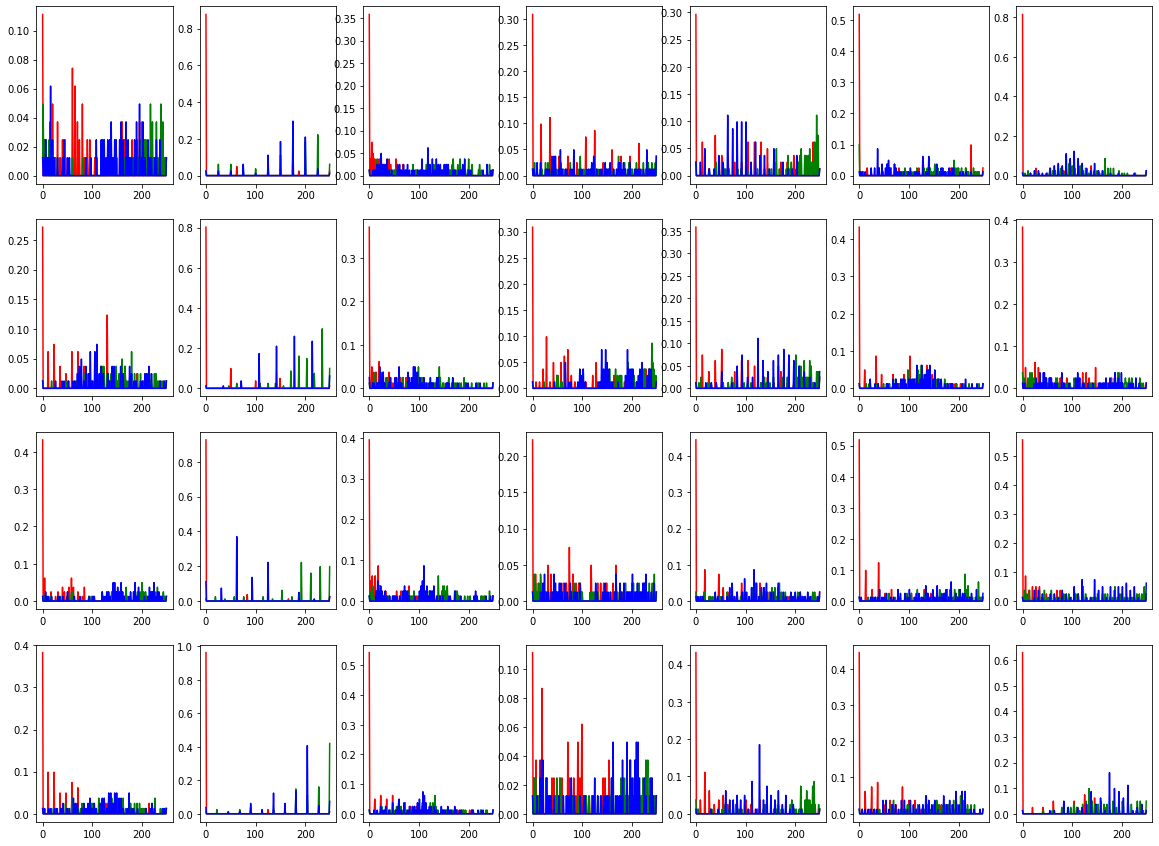

In [65]:
import numpy as np

perfect_hists = torch.empty((N, T, K, C, n_bins))
for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                perfect_hists[n, t, k, c] = torch.histc(perfect_kpt_patches[n, t, k, c], bins=n_bins)
                # Normalizing hists to probabilities 
                # (Each count devided by total number of counts)
                perfect_hists[n, t, k, c] /= torch.sum(perfect_hists[n, t, k, c])

fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 2], color='blue')
    

tensor([[0.4389, 0.8285, 0.2858, 0.4150, 0.4305, 0.3931, 0.5848],
        [0.4287, 0.8571, 0.3430, 0.4087, 0.4375, 0.4216, 0.3962],
        [0.3608, 0.8185, 0.3943, 0.3599, 0.3888, 0.4139, 0.4678]])
tensor(0.4702)


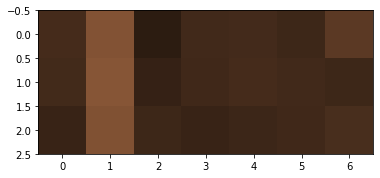

In [66]:
perfect_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        # perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        perfect_dist[k, t] = torch.norm(perfect_hists[0, t:t+1, k, :] - perfect_hists[0, t+1:t+2, k, :], p=hist_norm_p)
        """
        d = (perfect_hists[0, t:t+1, k, :] - perfect_hists[0, t+1:t+2, k, :])**2/\
            (perfect_hists[0, t:t+1, k, :] + perfect_hists[0, t+1:t+2, k, :])
        d = torch.nan_to_num(d, 0.0)
        d = torch.sum(d, dim=-1)
        perfect_dist[k, t] = torch.mean(d)
        """
        
print(perfect_dist.T)
        
plt.imshow(perfect_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(perfect_dist.mean())

In [67]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))

bad_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=bad_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))


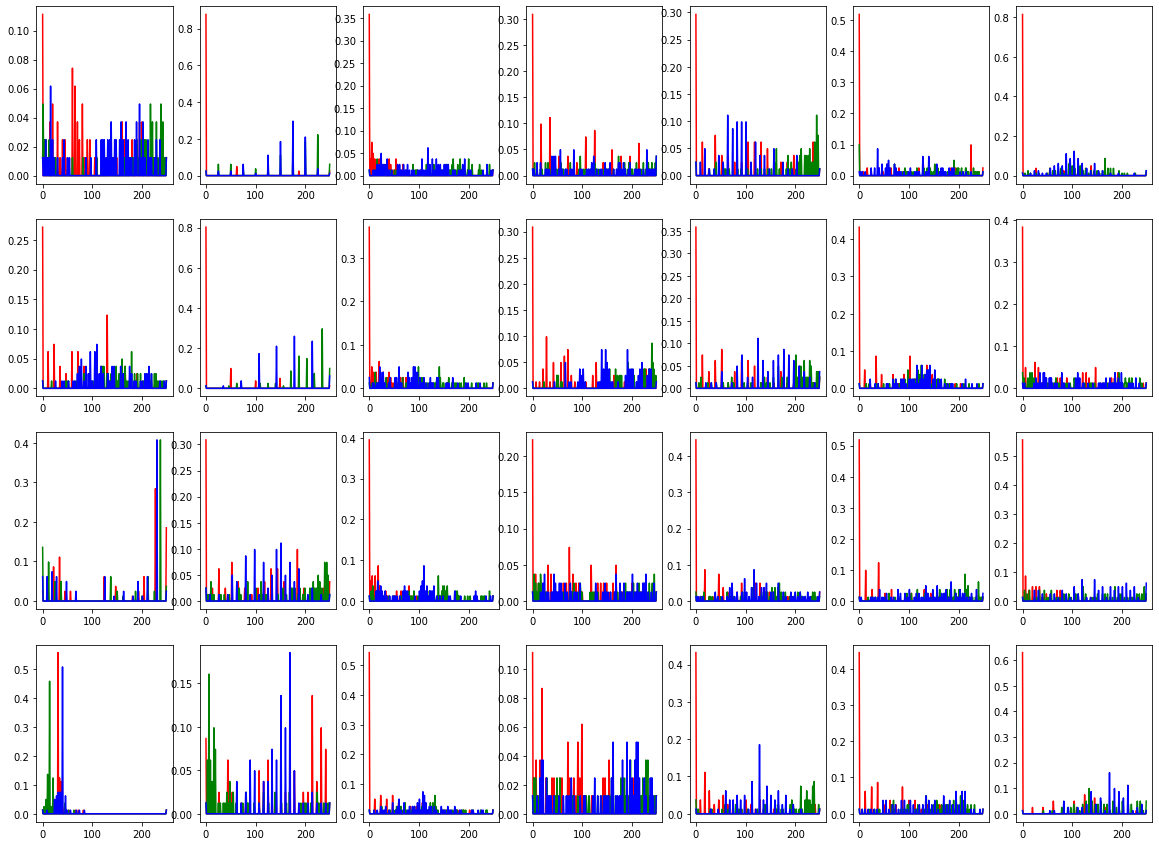

In [68]:
bad_hists = torch.empty((N, T, K, C, n_bins))
for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                bad_hists[n, t, k, c] = torch.histc(bad_kpt_patches[n, t, k, c], bins=n_bins)
                bad_hists[n, t, k, c] /= torch.sum(bad_hists[n, t, k, c])

fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 2], color='blue')

tensor([[0.4389, 0.8285, 0.2858, 0.4150, 0.4305, 0.3931, 0.5848],
        [0.8311, 0.8219, 0.3430, 0.4087, 0.4375, 0.4216, 0.3962],
        [1.1771, 0.5039, 0.3943, 0.3599, 0.3888, 0.4139, 0.4678]])
tensor(0.5116)


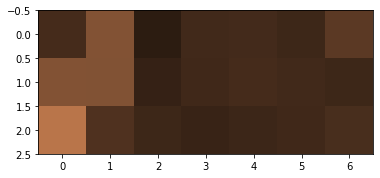

In [69]:
bad_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        # bad_dist[k, t] = dkl(bad_hists[0, t:t+1, k, :], bad_hists[0, t+1:t+2, k, :])
        bad_dist[k, t] = torch.norm(bad_hists[0, t:t+1, k, :] - bad_hists[0, t+1:t+2, k, :], p=hist_norm_p)
        """
        d = (bad_hists[0, t:t+1, k, :] - bad_hists[0, t+1:t+2, k, :])**2/\
            (bad_hists[0, t:t+1, k, :] + bad_hists[0, t+1:t+2, k, :])
        d = torch.nan_to_num(d, 0.0)
        d = torch.sum(d, dim=-1)
        bad_dist[k, t] = torch.mean(d)
        """
        
print(bad_dist.T)
        
plt.imshow(bad_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(bad_dist.mean())

In [70]:
random_kpt_coordinates = get_random_keypoints(T=sample_size).unsqueeze(0)
random_kpt_coordinates = random_kpt_coordinates.repeat((batch_size, 1, 1, 1))

random_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=random_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

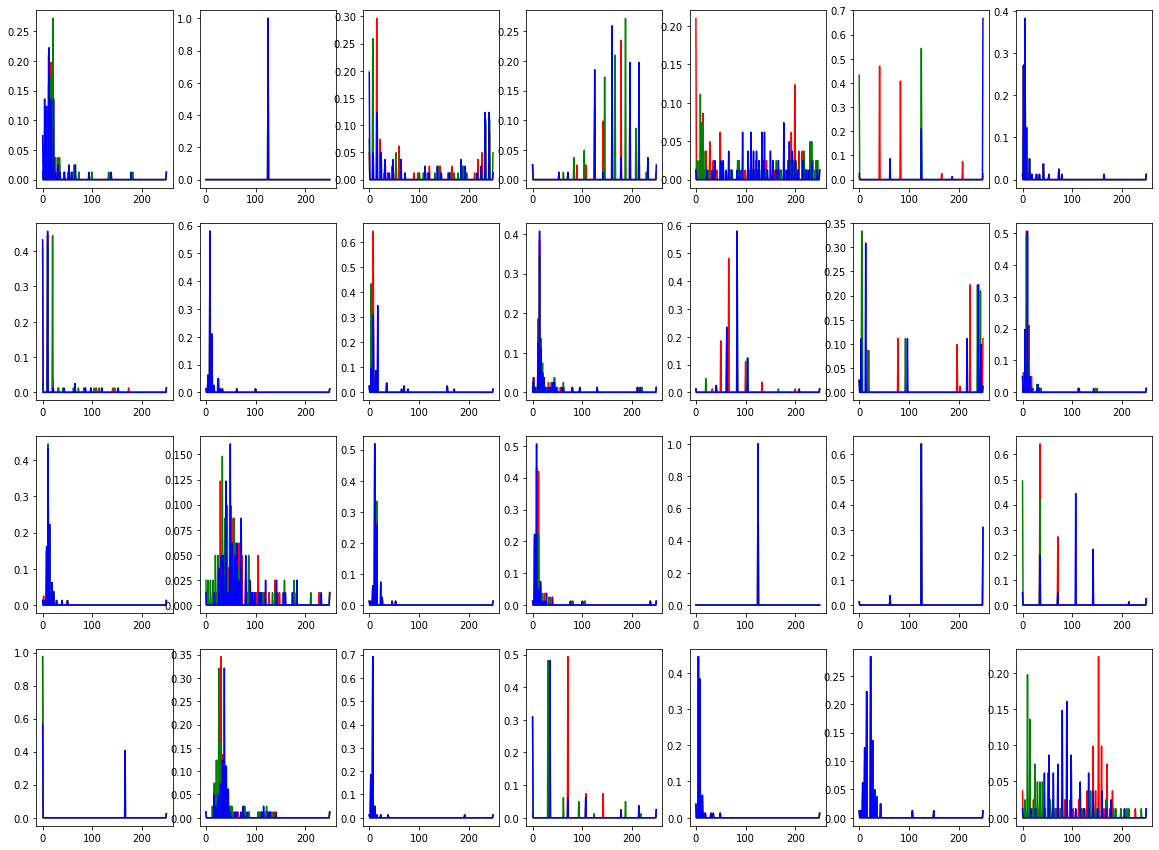

In [71]:
random_hists = torch.empty((N, T, K, C, n_bins))
for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                random_hists[n, t, k, c] = torch.histc(random_kpt_patches[n, t, k, c], bins=n_bins)
                random_hists[n, t, k, c] /= torch.sum(random_hists[n, t, k, c])

fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 2], color='blue')

tensor([[1.2158, 2.0410, 1.1190, 1.0277, 1.1117, 1.3961, 1.0385],
        [1.3874, 1.1600, 1.4411, 1.1838, 2.0240, 1.4358, 1.4285],
        [1.7711, 0.8092, 1.4879, 1.3653, 2.0125, 1.4216, 1.1672]])
tensor(1.3831)


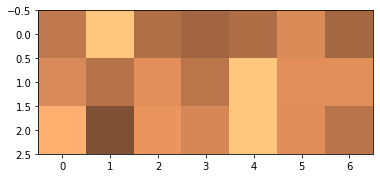

In [72]:
random_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        # random_dist[k, t] = dkl(random_hists[0, t:t+1, k, :], random_hists[0, t+1:t+2, k, :])
        random_dist[k, t] = torch.norm(random_hists[0, t:t+1, k, :] - random_hists[0, t+1:t+2, k, :], p=hist_norm_p)
        """
        d = (random_hists[0, t:t+1, k, :] - random_hists[0, t+1:t+2, k, :])**2/\
            (random_hists[0, t:t+1, k, :] + random_hists[0, t+1:t+2, k, :])
        d = torch.nan_to_num(d, 0.0)
        d = torch.sum(d, dim=-1)
        random_dist[k, t] = torch.mean(d)
        """

print(random_dist.T)
        
plt.imshow(random_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(random_dist.mean())

Tensor based loss formulation

In [73]:
H_t_perfect = perfect_hists.unsqueeze(1) - perfect_hists.unsqueeze(2)
H_t_perfect = torch.norm(H_t_perfect, p=hist_norm_p, dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_perfect = torch.sum(H_t_perfect, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_perfect))

tensor(0.4813)


In [74]:
H_t_bad = bad_hists.unsqueeze(1) - bad_hists.unsqueeze(2)
H_t_bad = torch.norm(H_t_bad, p=hist_norm_p, dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_bad = torch.sum(H_t_bad, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_bad))

tensor(0.5473)


In [75]:
H_t_random = random_hists.unsqueeze(1) - random_hists.unsqueeze(2)
H_t_random = torch.norm(H_t_random, p=hist_norm_p, dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_random = torch.sum(H_t_random, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_random))

tensor(1.3571)
